In [ ]:
### -------------------------- 生信分析基础 ------------------------------ ###
## contact: fuxin@singleronbio.com
## 富集分析：clusterProfiler::GO,KEGG,GSEA, GSVA::GSVA

In [1]:
library(tidyverse)
library(clusterProfiler)
library(org.Mm.eg.db) #富集分析GO & KEGG
library(msigdbr) #GSEA
library(enrichplot)
library(Seurat)
library(GSVA) # GSVA
library(limma)
library(ggplot2) #画图

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



clusterProfiler v3.18.1  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.


Attaching package: ‘clusterProfiler’


The following object is masked from ‘package:purrr’:

    simplify


The following object is masked from ‘package:stats’:

    filter


Loading required package: AnnotationDbi

Loading required package: stats4

Loadin

In [4]:
res_dir = "/SGRNJ03/randd/user/fuxin/PROJECTS/Bioinfo_Train"
sample = "PYF"
markers_file = paste0(res_dir,"/results/",sample,".allmarkers.tsv")
markers = readr::read_tsv(markers_file)
rds_file = paste0(res_dir,"/results/",sample,".rds")
rds = readRDS(rds_file)

Rows: 21003 Columns: 7

── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): gene
dbl (6): p_val, avg_log2FC, pct.1, pct.2, p_val_adj, cluster


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



In [5]:
markers%>%
    filter(cluster %in% c('10'))->markers_cluster10

In [6]:
genelist = markers_cluster10$gene
eg <- bitr(genelist, 
           fromType="SYMBOL", 
           toType=c("ENTREZID","ENSEMBL",'SYMBOL'),
           OrgDb=" org.Mm.eg.db")

Loading required package:  org.Mm.eg.db

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ org.Mm.eg.db’”
Loading required package:  org.Mm.eg.db

Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘ org.Mm.eg.db’”
'select()' returned 1:many mapping between keys and columns

Warning message in bitr(genelist, fromType = "SYMBOL", toType = c("ENTREZID", "ENSEMBL", :
“0.89% of input gene IDs are fail to map...”


In [7]:
# GO 富集
go <- enrichGO(eg$ENTREZID, 
               OrgDb = org.Mm.eg.db, 
               ont='ALL',
               pAdjustMethod = 'BH',
               pvalueCutoff = 0.05, 
               qvalueCutoff = 0.05,
               keyType = 'ENTREZID',
               readable = TRUE)

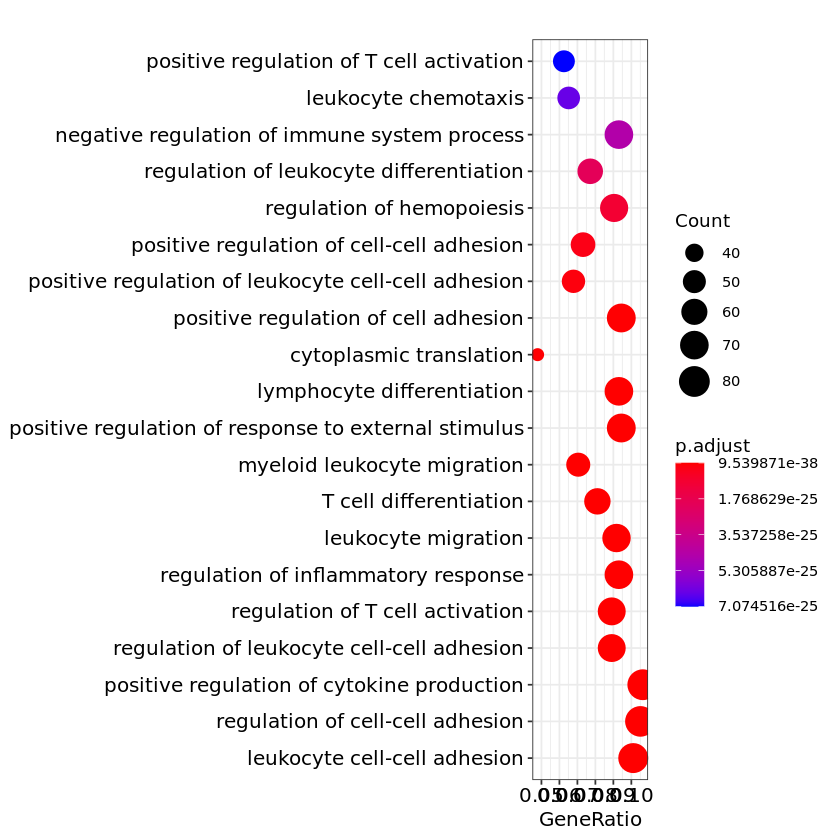

In [8]:
dotplot(go,showCategory=20,orderBy = "p.adjust")

In [9]:
# KEGG 富集
kegg <- enrichKEGG(eg$ENTREZID, 
                   organism = 'mmu',
                   keyType = 'kegg', 
                   pvalueCutoff = 0.05,
                   pAdjustMethod = 'BH', 
                   minGSSize = 3,
                   maxGSSize = 500,
                   qvalueCutoff = 0.05,
                   use_internal_data = FALSE)

Reading KEGG annotation online:


Reading KEGG annotation online:




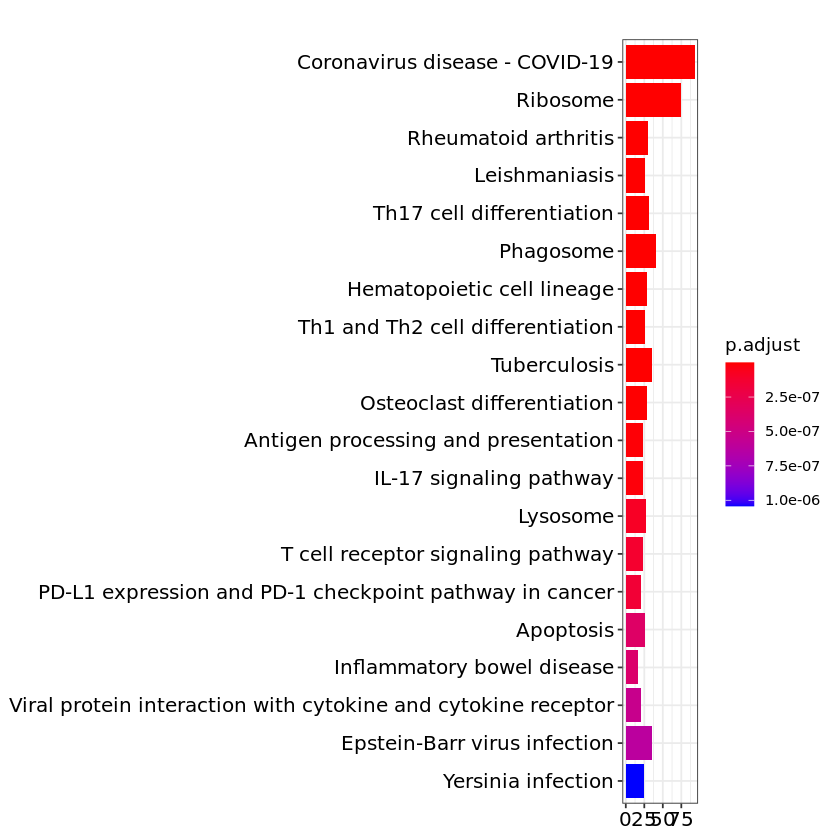

In [10]:
barplot(kegg,showCategory=20,orderBy = "p.adjust")

In [11]:
#  GSEA 富集
msig_c7 = msigdbr(species = "Mus musculus", category = "C7")
gsea_set = subset(msig_c7,select = c("gs_name","gene_symbol"))

In [12]:
markers_cluster10 <- markers_cluster10[order(markers_cluster10$avg_log2FC,decreasing = TRUE),]
gene_list = structure(markers_cluster10$avg_log2FC, names = markers_cluster10$gene)

In [13]:
gsea_res = GSEA(gene_list,TERM2GENE = gsea_set,eps = 0)

preparing geneSet collections...

GSEA analysis...

leading edge analysis...

done...



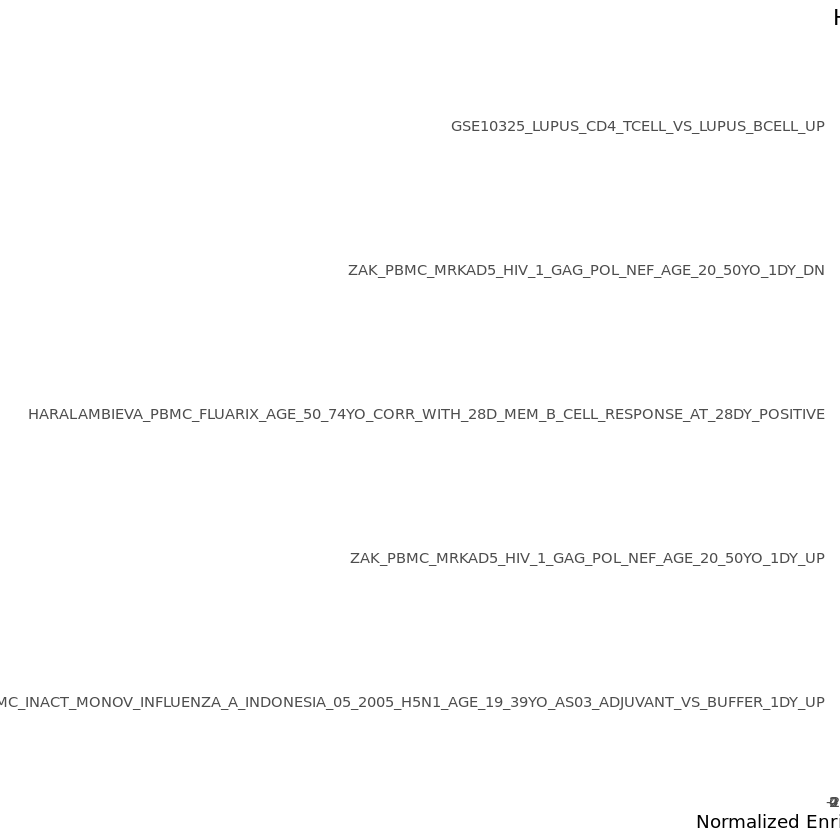

In [17]:
ggplot(gsea_res%>%filter(p.adjust<0.001)
           %>%head(n=5),
      aes(reorder(ID,NES),NES))+
geom_col(aes(fill = NES <7.5))+
coord_flip()+
labs(x = "", y = "Normalized Enrichment Score",
    title = "Hallmarks pathways NES from GSEA")+
theme_minimal()

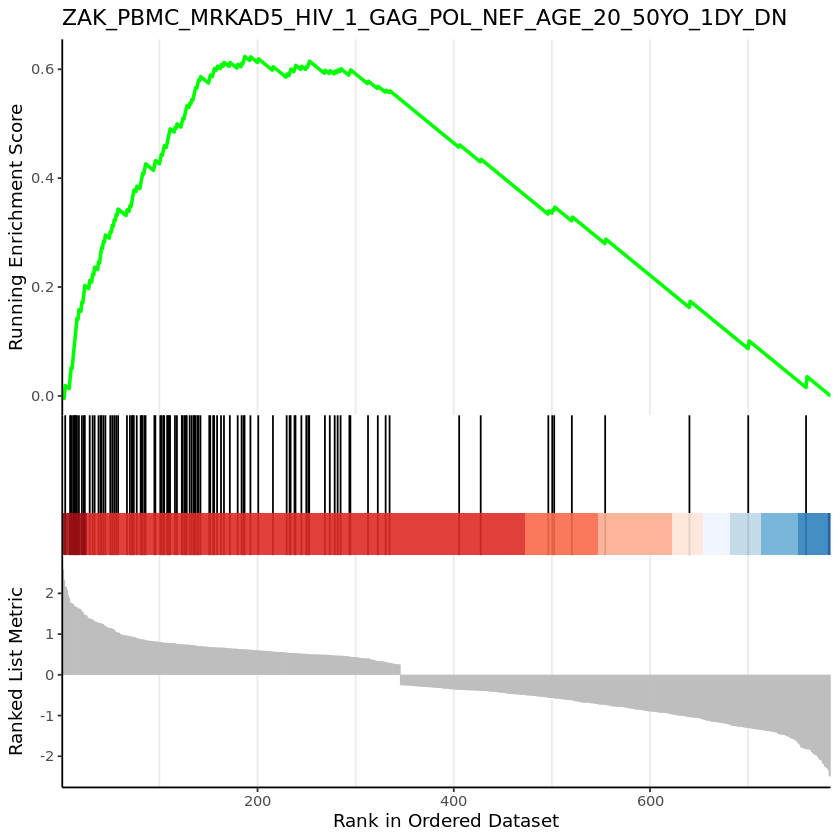

In [18]:
gseaplot2(gsea_res, geneSetID = 1,title = gsea_res$Description[1])

In [23]:
# GSVA 富集
Idents(rds) <- "RNA_snn_res.1"
expr <- AverageExpression(rds,assays = "RNA", slot = "data")[[1]]
expr <- expr[unique(markers$gene),]
expr<- as.matrix(expr)
head(expr)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
Hcar2,24.52737,3.930505,2.003273,1.812831,28.89513,1.049158,1.454940,2.227097,3.230210,1.367973,1.341150,1.478079,14.66730,1.692207,1.608174,1.634773,1.885102,17.81502,1.1978633
Acod1,48.20446,6.709277,4.752046,3.875070,68.16242,1.614471,3.575027,3.867376,4.683537,2.381628,2.754752,3.276409,42.36408,3.375781,3.326121,3.190239,2.628511,41.03514,0.4282382
Hdc,22.22700,3.474037,1.884763,1.721484,28.30292,1.025893,1.687740,1.646222,1.707180,1.176741,2.134044,1.459989,28.20331,1.278233,1.363888,1.563365,1.812016,16.26318,0.1522069
Cxcl2,432.28543,92.256394,87.947968,34.496381,525.52906,22.623448,91.081213,44.462582,133.306883,35.665748,31.694470,31.289934,315.20657,32.732675,91.582770,36.813808,40.882734,363.88758,20.2328966
Ccr1,24.52976,4.930278,4.630626,1.866467,27.91872,1.092385,4.166692,2.130503,6.255105,2.103662,2.066188,1.508530,15.56937,1.676800,4.167616,1.817656,1.913350,18.50104,0.0620467
Clec4d,28.07970,4.935761,4.112826,2.058574,32.44014,1.376165,5.211266,2.550193,10.472653,1.686061,2.209906,1.895342,24.94923,1.669811,4.935873,3.678383,3.280772,24.12175,0.2495290


In [24]:
genesets = msigdbr(species = "Mus musculus", category = "H")
genesets <- subset(genesets, select = c("gs_name","gene_symbol"))%>% as.data.frame()
genesets = split(genesets$gene_symbol, genesets$gs_name)

Estimating GSVA scores for 50 gene sets.
Estimating ECDFs with Gaussian kernels
  |======================================================================| 100%



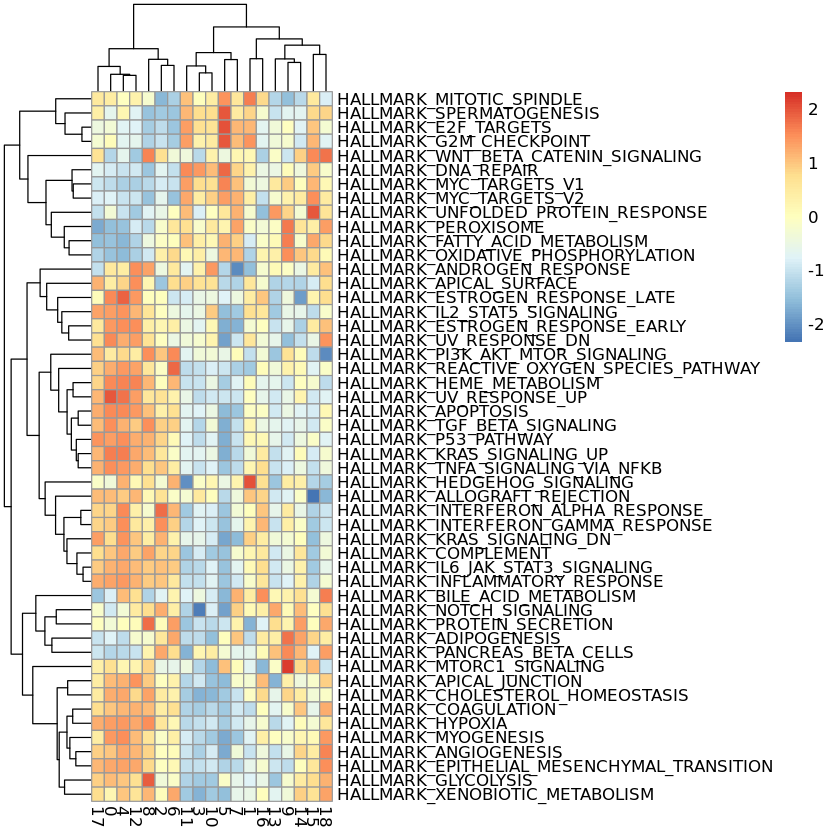

In [25]:
gsva.res <- gsva(expr, genesets, method = "gsva")
gsva.df <- data.frame(Genesets = rownames(gsva.res),gsva.res, check.names = FALSE)
pheatmap::pheatmap(gsva.res, show_colnames = TRUE, scale = "row")

In [26]:
#将cluster 3，5，10 设为case组，其余为control组
group_list = data.frame(sample = colnames(gsva.df)[-1], group = c(rep("con",3),rep("case",1),
                                                                  rep("con",1),rep("case",1),
                                                                  rep("con",4),rep("case",1),rep("con",8)))
group_list

sample,group
<chr>,<chr>
0,con
1,con
2,con
3,case
4,con
5,case
6,con
7,con
8,con


In [27]:
design <- model.matrix(~ 0 + factor(group_list$group))
colnames(design) <- levels(factor(group_list$group))
rownames(design ) <- colnames(gsva.res)
contrast.matrix = makeContrasts(con-case, levels = design)

In [28]:
#差异分析，case Vs con
fit = lmFit(gsva.res, design)
fit2 = contrasts.fit(fit, contrast.matrix)
fit2 = eBayes(fit2)
x <- topTable(fit2, coef = 1, n=Inf, adjust.method = "BH", sort.by = "P")
head(x)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HALLMARK_CHOLESTEROL_HOMEOSTASIS,0.6136401,0.018886861,3.933349,0.0005373551,0.02418527,-0.2264897
HALLMARK_NOTCH_SIGNALING,0.4673677,0.030251727,3.708163,0.0009674107,0.02418527,-0.7732132
HALLMARK_DNA_REPAIR,-0.4927951,-0.038420071,-3.379967,0.0022470644,0.03478956,-1.5525537
HALLMARK_MYOGENESIS,0.4660067,0.066143778,3.257774,0.0030587239,0.03478956,-1.8360789
HALLMARK_COAGULATION,0.5725205,0.043791850,3.130797,0.0041986333,0.03478956,-2.1261813
HALLMARK_XENOBIOTIC_METABOLISM,0.3703449,0.003419305,3.079607,0.0047650514,0.03478956,-2.2417210


In [29]:
pathways = str_replace(row.names(x),"HALLMARK_","")
df <- data.frame(ID = pathways, score = x$t)
cutoff = 0
df$group = cut(df$score, breaks = c(-Inf, cutoff, Inf),lable = c(1,2))
sortdf <- df[order(df$score),]
sortdf$ID <- factor(sortdf$ID, levels = sortdf$ID)

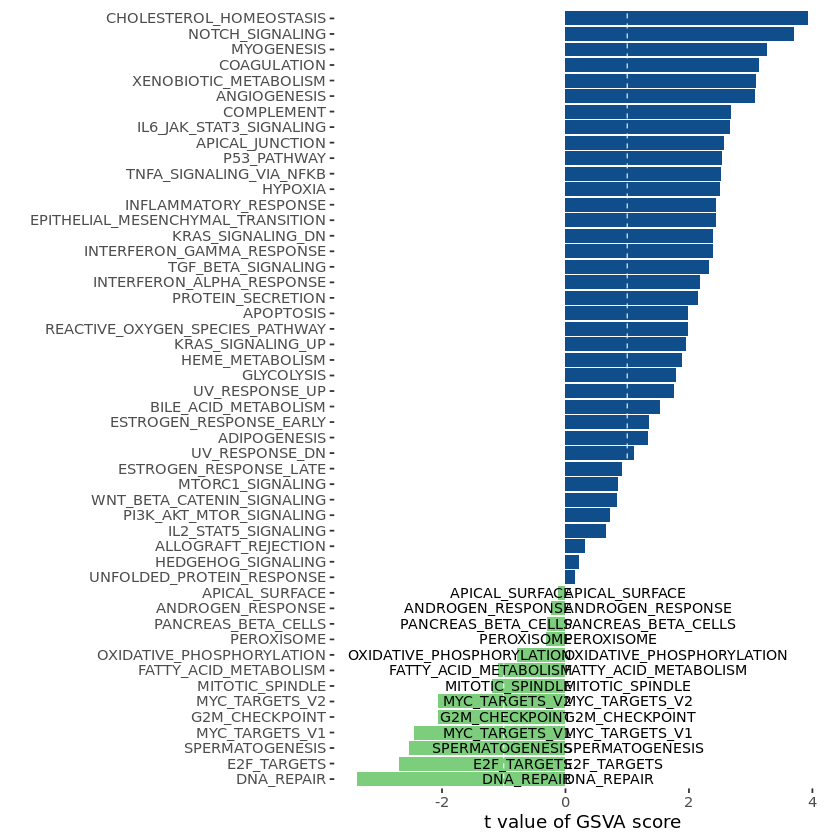

In [30]:
ggplot(sortdf,aes(ID, score, fill = group))+
    geom_bar(stat = "identity")+
    coord_flip()+
    scale_fill_manual(values = c("palegreen3","dodgerblue4"),guide = "none")+
    geom_hline(yintercept = c(-1, 1),
              color = "white",
              linetype = 2,
              size = 0.3)+
    geom_text(data = subset(df, score<0),
             aes(x = ID, y=0.1, label =ID, color = group),
             size = 3,
             hjust = "outward")+
    geom_text(data = subset(df, score<0),
             aes(x = ID, y= -0.1, label =paste0(" ",ID), color = group),
             size = 3,
             hjust = "inward")+
    scale_colour_manual(values = c("black","black"),guide = "none")+
    xlab("")+
    ylab("t value of GSVA score")+
    theme_bw()+
    theme(panel.grid = element_blank())+
    theme(panel.border = element_blank())